In [29]:
 # data science imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

# data processing
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage

# unsupervised algorithms
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering

# metrics
from sklearn.metrics import silhouette_samples, silhouette_score

In [30]:
# pandas display options
pd.set_option('display.max_columns', None)
pd.set_option("display.max_colwidth", None)
pd.set_option("display.max_rows", None)

In [31]:
file = 'crypto_data.csv'
df = pd.read_csv(file)
df.head()

,Unnamed: 0,CoinName,Algorithm,IsTrading,ProofType,TotalCoinsMined,TotalCoinSupply
0,42,42 Coin,Scrypt,True,PoW/PoS,4.199995e+01,42
1,365,365Coin,X11,True,PoW/PoS,NaN,2300000000
2,404,404Coin,Scrypt,True,PoW/PoS,1.055185e+09,532000000
3,611,SixEleven,SHA-256,True,PoW,NaN,611000
4,808,808,SHA-256,True,PoW/PoS,0.000000e+00,0


In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1252 entries, 0 to 1251
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Unnamed: 0       1252 non-null   object 
 1   CoinName         1252 non-null   object 
 2   Algorithm        1252 non-null   object 
 3   IsTrading        1252 non-null   bool   
 4   ProofType        1252 non-null   object 
 5   TotalCoinsMined  744 non-null    float64
 6   TotalCoinSupply  1252 non-null   object 
dtypes: bool(1), float64(1), object(5)
memory usage: 60.0+ KB


# Data Preparation

In [33]:
# Discard all cryptocurrencies that are not being traded.(False)
df.IsTrading.value_counts()

True     1144
False     108
Name: IsTrading, dtype: int64

In [34]:
# filter for currencies that are currently being traded.
# Reset the index to recount our rows
df_sub = df.loc[df.IsTrading].reset_index(drop=True)
df_sub.head()

,Unnamed: 0,CoinName,Algorithm,IsTrading,ProofType,TotalCoinsMined,TotalCoinSupply
0,42,42 Coin,Scrypt,True,PoW/PoS,4.199995e+01,42
1,365,365Coin,X11,True,PoW/PoS,NaN,2300000000
2,404,404Coin,Scrypt,True,PoW/PoS,1.055185e+09,532000000
3,611,SixEleven,SHA-256,True,PoW,NaN,611000
4,808,808,SHA-256,True,PoW/PoS,0.000000e+00,0


In [35]:
df_sub.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1144 entries, 0 to 1143
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Unnamed: 0       1144 non-null   object 
 1   CoinName         1144 non-null   object 
 2   Algorithm        1144 non-null   object 
 3   IsTrading        1144 non-null   bool   
 4   ProofType        1144 non-null   object 
 5   TotalCoinsMined  685 non-null    float64
 6   TotalCoinSupply  1144 non-null   object 
dtypes: bool(1), float64(1), object(5)
memory usage: 54.9+ KB


In [36]:
# Remove all rows that have at least one null value. "TotalCoinsMined"
# we are going to drop 459 Rows now due to null values
df_sub = df_sub.dropna(how="any").reset_index(drop=True)
df_sub.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 685 entries, 0 to 684
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Unnamed: 0       685 non-null    object 
 1   CoinName         685 non-null    object 
 2   Algorithm        685 non-null    object 
 3   IsTrading        685 non-null    bool   
 4   ProofType        685 non-null    object 
 5   TotalCoinsMined  685 non-null    float64
 6   TotalCoinSupply  685 non-null    object 
dtypes: bool(1), float64(1), object(5)
memory usage: 32.9+ KB


In [37]:
# Filter for cryptocurrencies that have been mined. That is, the total coins mined should be greater than zero.
mask = df_sub.TotalCoinsMined > 0
df_sub = df_sub.loc[mask].reset_index(drop=True)
df_sub.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 532 entries, 0 to 531
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Unnamed: 0       532 non-null    object 
 1   CoinName         532 non-null    object 
 2   Algorithm        532 non-null    object 
 3   IsTrading        532 non-null    bool   
 4   ProofType        532 non-null    object 
 5   TotalCoinsMined  532 non-null    float64
 6   TotalCoinSupply  532 non-null    object 
dtypes: bool(1), float64(1), object(5)
memory usage: 25.6+ KB


In [38]:
#Save the crypto names for plotting purposes
crypto_names = df_sub.CoinName

# In order for your dataset to be comprehensible to a machine learning algorithm, its data should be numeric.
# Since the coin names do not contribute to the analysis of the data, delete the CoinName from the original dataframe.
df_sub = df_sub.drop(["Unnamed: 0", 'CoinName'], axis=1)
df_sub.head()

,Algorithm,IsTrading,ProofType,TotalCoinsMined,TotalCoinSupply
0,Scrypt,True,PoW/PoS,4.199995e+01,42
1,Scrypt,True,PoW/PoS,1.055185e+09,532000000
2,X13,True,PoW/PoS,2.927942e+10,314159265359
3,SHA-256,True,PoW,1.792718e+07,21000000
4,Ethash,True,PoW,1.076842e+08,0


In [39]:
# Total coin supply is a number but the data type is a object.
# change it to a flot because we have a very high number
df_sub["TotalCoinSupply"] = df_sub.TotalCoinSupply.astype(float)
df_sub.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 532 entries, 0 to 531
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Algorithm        532 non-null    object 
 1   IsTrading        532 non-null    bool   
 2   ProofType        532 non-null    object 
 3   TotalCoinsMined  532 non-null    float64
 4   TotalCoinSupply  532 non-null    float64
dtypes: bool(1), float64(2), object(2)
memory usage: 17.3+ KB


In [40]:
df_sub["IsTrading"] = [1 if x == "f" else 0 for x in df_sub.IsTrading]
df_sub.head()

,Algorithm,IsTrading,ProofType,TotalCoinsMined,TotalCoinSupply
0,Scrypt,0,PoW/PoS,4.199995e+01,4.200000e+01
1,Scrypt,0,PoW/PoS,1.055185e+09,5.320000e+08
2,X13,0,PoW/PoS,2.927942e+10,3.141593e+11
3,SHA-256,0,PoW,1.792718e+07,2.100000e+07
4,Ethash,0,PoW,1.076842e+08,0.000000e+00


In [41]:
df_sub.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 532 entries, 0 to 531
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Algorithm        532 non-null    object 
 1   IsTrading        532 non-null    int64  
 2   ProofType        532 non-null    object 
 3   TotalCoinsMined  532 non-null    float64
 4   TotalCoinSupply  532 non-null    float64
dtypes: float64(2), int64(1), object(2)
memory usage: 20.9+ KB


In [42]:
print(df_sub.Algorithm.nunique())
df_sub.Algorithm.value_counts()

71


Scrypt                    182
X11                        73
SHA-256                    48
CryptoNight                19
X13                        17
PoS                        17
Quark                      13
Equihash                   12
NeoScrypt                  10
NIST5                      10
Multiple                    9
Ethash                      9
DPoS                        7
XEVAN                       6
CryptoNight-V7              5
X16R                        4
Lyra2RE                     4
Groestl                     4
X15                         4
SHA-256D                    4
Lyra2REv2                   4
Lyra2Z                      4
Blake                       3
QuBit                       3
POS 3.0                     3
Dagger                      3
SHA-512                     3
CryptoNight Heavy           2
Skein                       2
Keccak                      2
C11                         2
PHI1612                     2
BLAKE256                    2
Blake2b   

In [43]:
# we only want the values that appear less than 10 times
algs = df_sub.Algorithm.value_counts()
algs_replace = list(algs[algs < 10].index)
algs_replace

['Multiple',
 'Ethash',
 'DPoS',
 'XEVAN',
 'CryptoNight-V7',
 'X16R',
 'Lyra2RE',
 'Groestl',
 'X15',
 'SHA-256D',
 'Lyra2REv2',
 'Lyra2Z',
 'Blake',
 'QuBit',
 'POS 3.0',
 'Dagger',
 'SHA-512',
 'CryptoNight Heavy',
 'Skein',
 'Keccak',
 'C11',
 'PHI1612',
 'BLAKE256',
 'Blake2b',
 'SHA3',
 'Jump Consistent Hash',
 'SHA-256 + Hive',
 'Proof-of-Authority',
 'VBFT',
 'Leased POS',
 'IMesh',
 'Semux BFT consensus',
 'Green Protocol',
 'HMQ1725',
 'Equihash+Scrypt',
 'Tribus',
 'Exosis',
 'ECC 256K1',
 'Proof-of-BibleHash',
 'Cryptonight-GPU',
 'X14',
 'SkunkHash',
 'POS 2.0',
 'HybridScryptHash256',
 'Shabal256',
 'Counterparty',
 'Stanford Folding',
 'M7 POW',
 'QUAIT',
 '1GB AES Pattern Search',
 'X11GOST',
 'Dagger-Hashimoto',
 'Blake2S',
 '536',
 'Argon2d',
 'Cloverhash',
 'Time Travel',
 'SkunkHash v2 Raptor',
 'VeChainThor Authority',
 'Ouroboros',
 'TRC10']

In [44]:
# All those valuse can be written to a column called other
mask = df_sub.Algorithm.isin(algs_replace)
df_sub.loc[mask, "Algorithm"] = "Other"

df_sub.Algorithm.value_counts()

Scrypt         182
Other          131
X11             73
SHA-256         48
CryptoNight     19
X13             17
PoS             17
Quark           13
Equihash        12
NeoScrypt       10
NIST5           10
Name: Algorithm, dtype: int64

In [45]:
print(df_sub.ProofType.nunique())
df_sub.ProofType.value_counts()

25


PoW                     237
PoW/PoS                 176
PoS                      86
DPoS                      9
PoC                       3
PoS/PoW                   2
POBh                      1
LPoS                      1
Proof of Trust            1
Pos                       1
DPOS                      1
Zero-Knowledge Proof      1
HPoW                      1
PoA                       1
PoW + Hive                1
PoW/PoS                   1
PoW and PoS               1
Proof of Authority        1
TPoS                      1
PoW/PoW                   1
dPoW/PoW                  1
PoW/nPoS                  1
PoST                      1
PoS/PoW/PoT               1
PoS/LPoS                  1
Name: ProofType, dtype: int64

In [46]:
# Match the value counts of one with their parent category column
df_sub.loc[df_sub.ProofType == 'Pos', "ProofType"] = "PoS"
df_sub.loc[df_sub.ProofType == 'PoW and PoS', "ProofType"] = "PoW/PoS"
df_sub.loc[df_sub.ProofType == 'PoS/PoW', "ProofType"] = "PoW/PoS"
df_sub.loc[df_sub.ProofType == 'PoW/PoS ', "ProofType"] = "PoW/PoS"


In [47]:
# we only want the values that appear less than 10 times
pts = df_sub.ProofType.value_counts()
pts_replace = list(pts[pts < 30].index)
pts_replace

['DPoS',
 'PoC',
 'PoW + Hive',
 'LPoS',
 'Proof of Trust',
 'DPOS',
 'Zero-Knowledge Proof',
 'HPoW',
 'PoA',
 'TPoS',
 'POBh',
 'Proof of Authority',
 'PoW/PoW',
 'dPoW/PoW',
 'PoW/nPoS',
 'PoST',
 'PoS/PoW/PoT',
 'PoS/LPoS']

In [48]:
# All those valuse can be written to a column called other
mask = df_sub.ProofType.isin(pts_replace)
df_sub.loc[mask, "ProofType"] = "Other"

df_sub.ProofType.value_counts()

PoW        237
PoW/PoS    180
PoS         87
Other       28
Name: ProofType, dtype: int64

In [49]:
oh_cols = ["Algorithm", "ProofType"]
df_oh = df_sub.loc[:, oh_cols]

df_oh = pd.get_dummies(df_oh)
df_oh.head()

,Algorithm_CryptoNight,Algorithm_Equihash,Algorithm_NIST5,Algorithm_NeoScrypt,Algorithm_Other,Algorithm_PoS,Algorithm_Quark,Algorithm_SHA-256,Algorithm_Scrypt,Algorithm_X11,Algorithm_X13,ProofType_Other,ProofType_PoS,ProofType_PoW,ProofType_PoW/PoS
0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
3,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
4,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0


In [50]:
num_cols = ["TotalCoinsMined", "TotalCoinSupply"]
df_num = df_sub.loc[:, num_cols]


scaler = StandardScaler().fit(df_num)
df_scale = pd.DataFrame(scaler.transform(df_num), columns=df_num.columns)
df_scale.head()

,TotalCoinsMined,TotalCoinSupply
0,-0.117108,-0.152870
1,-0.093970,-0.145009
2,0.524946,4.489424
3,-0.116715,-0.152560
4,-0.114747,-0.152870


In [51]:
#Combine our scale data and our oneline encoded df
df_train = pd.concat([df_scale, df_oh], axis=1)
df_train.head()

,TotalCoinsMined,TotalCoinSupply,Algorithm_CryptoNight,Algorithm_Equihash,Algorithm_NIST5,Algorithm_NeoScrypt,Algorithm_Other,Algorithm_PoS,Algorithm_Quark,Algorithm_SHA-256,Algorithm_Scrypt,Algorithm_X11,Algorithm_X13,ProofType_Other,ProofType_PoS,ProofType_PoW,ProofType_PoW/PoS
0,-0.117108,-0.152870,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
1,-0.093970,-0.145009,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
2,0.524946,4.489424,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
3,-0.116715,-0.152560,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
4,-0.114747,-0.152870,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0


In [52]:
# TSNE
tsne = TSNE(random_state=42)
tsne_features = tsne.fit_transform(df_train)
print(tsne_features.shape)

tsne_df = pd.DataFrame(tsne_features, columns=["Feature1", "Feature2"])
tsne_df.head() 

(532, 2)


,Feature1,Feature2
0,-20.977303,-3.463734
1,-26.038897,0.918876
2,-0.414014,10.426276
3,8.009327,5.395653
4,19.255877,2.025513


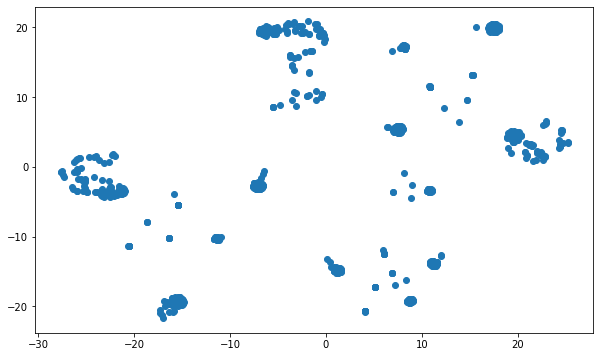

In [53]:
 plt.figure(figsize=(10, 6))
plt.scatter(tsne_df["Feature1"], tsne_df["Feature2"])
plt.show() 

In [54]:
# check for correlation
corrs = df_train.corr()
corrs

,TotalCoinsMined,TotalCoinSupply,Algorithm_CryptoNight,Algorithm_Equihash,Algorithm_NIST5,Algorithm_NeoScrypt,Algorithm_Other,Algorithm_PoS,Algorithm_Quark,Algorithm_SHA-256,Algorithm_Scrypt,Algorithm_X11,Algorithm_X13,ProofType_Other,ProofType_PoS,ProofType_PoW,ProofType_PoW/PoS
TotalCoinsMined,1.000000,0.702301,0.046358,-0.015083,-0.004300,-0.014830,0.064477,-0.020827,-0.018368,-0.025781,-0.009377,-0.042141,0.007338,0.190232,-0.033243,-0.017466,-0.045446
TotalCoinSupply,0.702301,1.000000,0.191816,-0.017729,-0.014702,-0.020049,0.025065,-0.027379,-0.023895,-0.034459,-0.015754,-0.049680,0.022187,0.116940,-0.039411,0.033228,-0.059287
Algorithm_CryptoNight,0.046358,0.191816,1.000000,-0.029235,-0.026637,-0.026637,-0.109997,-0.034965,-0.030458,-0.060606,-0.138778,-0.076749,-0.034965,-0.045361,-0.085094,0.214711,-0.137620
Algorithm_Equihash,-0.015083,-0.017729,-0.029235,1.000000,-0.021026,-0.021026,-0.086827,-0.027600,-0.024042,-0.047840,-0.109545,-0.060582,-0.027600,0.020887,-0.032941,0.118542,-0.108631
Algorithm_NIST5,-0.004300,-0.014702,-0.026637,-0.021026,1.000000,-0.019157,-0.079109,-0.025147,-0.021905,-0.043588,-0.099808,-0.055198,-0.025147,-0.032623,-0.023776,-0.068363,0.105794
Algorithm_NeoScrypt,-0.014830,-0.020049,-0.026637,-0.021026,-0.019157,1.000000,-0.079109,-0.025147,-0.021905,-0.043588,-0.099808,-0.055198,-0.025147,-0.032623,-0.061199,0.070876,-0.011217
Algorithm_Other,0.064477,0.025065,-0.109997,-0.086827,-0.079109,-0.079109,1.000000,-0.103845,-0.090459,-0.179995,-0.412159,-0.227939,-0.103845,0.197450,-0.004989,0.075855,-0.168966
Algorithm_PoS,-0.020827,-0.027379,-0.034965,-0.027600,-0.025147,-0.025147,-0.103845,1.000000,-0.028755,-0.057216,-0.131015,-0.072456,-0.033010,0.005038,0.382008,-0.162849,-0.129923
Algorithm_Quark,-0.018368,-0.023895,-0.030458,-0.024042,-0.021905,-0.021905,-0.090459,-0.028755,1.000000,-0.049841,-0.114127,-0.063117,-0.028755,-0.037304,0.160438,-0.117362,0.015477
Algorithm_SHA-256,-0.025781,-0.034459,-0.060606,-0.047840,-0.043588,-0.043588,-0.179995,-0.057216,-0.049841,1.000000,-0.227091,-0.125589,-0.057216,-0.044845,-0.015071,0.047739,-0.017203


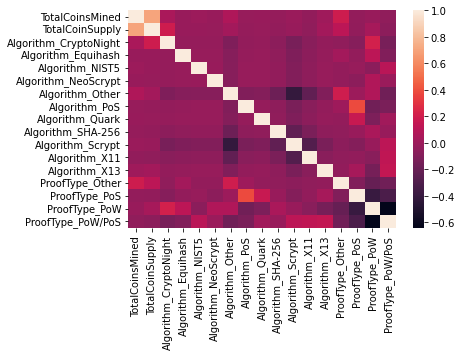

In [55]:
sns.heatmap(corrs)
plt.show()

[0.495, 0.118, 0.089, 0.082, 0.059, 0.05, 0.031, 0.018, 0.015, 0.009, 0.008, 0.008, 0.006, 0.006, 0.005, 0.0, 0.0]


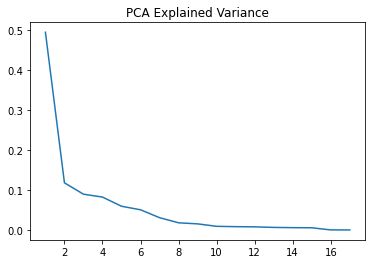

In [56]:
 # PCA

# Initialize PCA model
pca = PCA(n_components=len(df_train.columns))
pca.fit(df_train)

print([round(x, 3) for x in pca.explained_variance_ratio_])
plt.plot(range(1,len(df_train.columns)+1), pca.explained_variance_ratio_)
plt.title("PCA Explained Variance")
plt.show()

In [61]:
# creates a model that will preserve approximately 99% of the explained varianc
 # PCA

# Initialize PCA model
pca = PCA(n_components=0.99)
pca.fit(df_train)

print([round(x, 3) for x in pca.explained_variance_ratio_])
# plt.plot(range(1,len(df_train.columns)+1), pca.explained_variance_ratio_)
# plt.title("PCA Explained Variance")
# plt.show()

[0.495, 0.118, 0.089, 0.082, 0.059, 0.05, 0.031, 0.018, 0.015, 0.009, 0.008, 0.008, 0.006, 0.006]


In [62]:
#create a new dataframe that takes the columns from the train data
# convert those columns to features
df_pca = pd.DataFrame(pca.transform(df_train))
df_pca.columns = [f"Feature {x}" for x in range(1, len(pca.explained_variance_ratio_)+1)]
df_pca.head()

,Feature 1,Feature 2,Feature 3,Feature 4,Feature 5,Feature 6,Feature 7,Feature 8,Feature 9,Feature 10,Feature 11,Feature 12,Feature 13,Feature 14
0,-0.217131,-0.896267,0.378638,-0.370731,-0.087521,-0.288928,-0.000649,-0.027602,-0.027241,-0.053224,0.013468,-0.011570,0.019863,-0.022797
1,-0.195243,-0.898326,0.370452,-0.377274,-0.088020,-0.287457,-0.000382,-0.028807,-0.027389,-0.053424,0.013386,-0.011628,0.019930,-0.022855
2,3.523125,-0.476285,2.171310,1.972656,-0.198131,-0.111387,0.210601,-0.188368,0.323573,0.827363,-0.138865,-0.204003,-0.100646,-0.063712
3,-0.185170,0.651278,-0.010801,-0.094727,-0.198288,0.454131,0.829598,0.195923,-0.272624,0.029465,0.002014,-0.024169,-0.037363,-0.017090
4,-0.156799,0.846609,-0.364278,0.197044,-0.274519,-0.430230,-0.083059,-0.115133,-0.092318,0.025767,0.027577,-0.011910,-0.031834,-0.018015


In [63]:
# TSNE
tsne = TSNE(random_state=42)
tsne_features = tsne.fit_transform(df_pca)
print(tsne_features.shape)

tsne_df = pd.DataFrame(tsne_features, columns=["Feature1", "Feature2"])
tsne_df.head()

(532, 2)


,Feature1,Feature2
0,-23.904505,-9.105062
1,-31.115179,-6.904202
2,10.196150,10.187701
3,-3.646305,-9.036114
4,-8.644919,14.394348


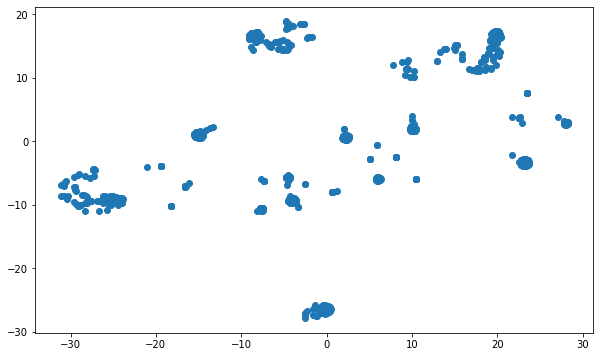

In [64]:
 plt.figure(figsize=(10, 6))
plt.scatter(tsne_df["Feature1"], tsne_df["Feature2"])
plt.show() 

In [65]:
# creates a model that will preserve approximately 90% of the explained varianc
 # PCA

# Initialize PCA model
pca = PCA(n_components=0.90)
pca.fit(df_train)

print([round(x, 3) for x in pca.explained_variance_ratio_])
# plt.plot(range(1,len(df_train.columns)+1), pca.explained_variance_ratio_)
# plt.title("PCA Explained Variance")
# plt.show()

[0.495, 0.118, 0.089, 0.082, 0.059, 0.05, 0.031]


In [66]:
#create a new dataframe that takes the columns from the train data
# convert those columns to features
df_pca = pd.DataFrame(pca.transform(df_train))
df_pca.columns = [f"Feature {x}" for x in range(1, len(pca.explained_variance_ratio_)+1)]
df_pca.head()

,Feature 1,Feature 2,Feature 3,Feature 4,Feature 5,Feature 6,Feature 7
0,-0.217131,-0.896267,0.378638,-0.370731,-0.087521,-0.288928,-0.000649
1,-0.195243,-0.898326,0.370452,-0.377274,-0.088020,-0.287457,-0.000382
2,3.523125,-0.476285,2.171310,1.972656,-0.198131,-0.111387,0.210601
3,-0.185170,0.651278,-0.010801,-0.094727,-0.198288,0.454131,0.829598
4,-0.156799,0.846609,-0.364278,0.197044,-0.274519,-0.430230,-0.083059


In [67]:
# TSNE
tsne = TSNE(random_state=42)
tsne_features = tsne.fit_transform(df_pca)
print(tsne_features.shape)

tsne_df = pd.DataFrame(tsne_features, columns=["Feature1", "Feature2"])
tsne_df.head()

(532, 2)


,Feature1,Feature2
0,-15.179930,-24.992092
1,-9.389144,-25.870975
2,5.910478,11.978151
3,-13.760137,11.623626
4,30.633718,-15.522095


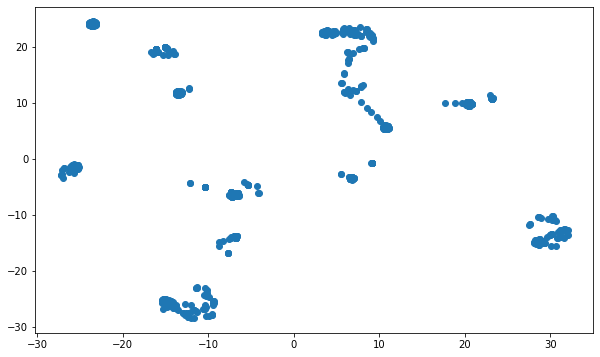

In [68]:
 plt.figure(figsize=(10, 6))
plt.scatter(tsne_df["Feature1"], tsne_df["Feature2"])
plt.show() 

C:\Users\malac\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


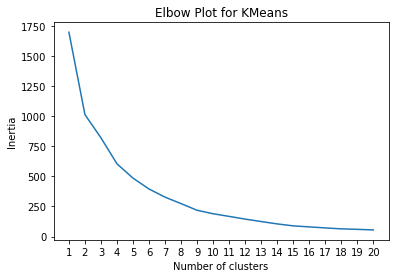

In [70]:
# KMEANS

inertia = []
# Same as k = list(range(1, 11))
k = list(range(1, 21))


# Looking for the best k
for i in k:
    km = KMeans(n_clusters=i, random_state=42)
    km.fit(df_pca)
    inertia.append(km.inertia_)

# Define a DataFrame to plot the Elbow Curve using hvPlot
elbow_data = {"k": k, "inertia": inertia}
df_elbow = pd.DataFrame(elbow_data)

plt.plot(df_elbow['k'], df_elbow['inertia'])
plt.xticks(range(1,21))
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title("Elbow Plot for KMeans")
plt.show()

In [73]:
def getSilhouette(X, range_n_clusters, model = "kmeans"):
    for n_clusters in range_n_clusters:

        # Create a subplot with 1 row and 2 columns
        fig, ax1 = plt.subplots(1, 1)
        fig.set_size_inches(18, 7)

        # The 1st subplot is the silhouette plot
        # The silhouette coefficient can range from -1, 1 but in this example all
        # lie within [-0.1, 1]
        ax1.set_xlim([-0.1, 1])
        # The (n_clusters+1)*10 is for inserting blank space between silhouette
        # plots of individual clusters, to demarcate them clearly.
        ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

        # Initialize the clusterer with n_clusters value and a random generator
        # seed of 10 for reproducibility.
        if model == "kmeans":
            clusterer = KMeans(n_clusters=n_clusters, random_state=42)
        else:
            clusterer = AgglomerativeClustering(n_clusters=n_clusters,
                                 affinity='euclidean',
                                 linkage='ward')
            
        cluster_labels = clusterer.fit_predict(X)

        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed
        # clusters
        silhouette_avg = silhouette_score(X, cluster_labels)
        print(
            "For n_clusters =",
            n_clusters,
            "The average silhouette_score is :",
            silhouette_avg,
        )

        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(X, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(
                np.arange(y_lower, y_upper),
                0,
                ith_cluster_silhouette_values,
                facecolor=color,
                edgecolor=color,
                alpha=0.7,
            )

            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])


        plt.suptitle(
            f"Silhouette analysis for {model} clustering on sample data with n_clusters = %d"
            % n_clusters,
            fontsize=14,
            fontweight="bold",
        )

    plt.show()

For n_clusters = 2 The average silhouette_score is : 0.9189199587280652
For n_clusters = 3 The average silhouette_score is : 0.3104849875732995
For n_clusters = 4 The average silhouette_score is : 0.3126734740451851
For n_clusters = 5 The average silhouette_score is : 0.3814207230365571
For n_clusters = 6 The average silhouette_score is : 0.40834973335984087
For n_clusters = 7 The average silhouette_score is : 0.4271938623703271
For n_clusters = 8 The average silhouette_score is : 0.4821305869369048
For n_clusters = 9 The average silhouette_score is : 0.5556464464937946
For n_clusters = 10 The average silhouette_score is : 0.5982163336272469
For n_clusters = 11 The average silhouette_score is : 0.5965065177557117
For n_clusters = 12 The average silhouette_score is : 0.6371439214155025
For n_clusters = 13 The average silhouette_score is : 0.6729904117882306
For n_clusters = 14 The average silhouette_score is : 0.7121720045952723
For n_clusters = 15 The average silhouette_score is : 0.74

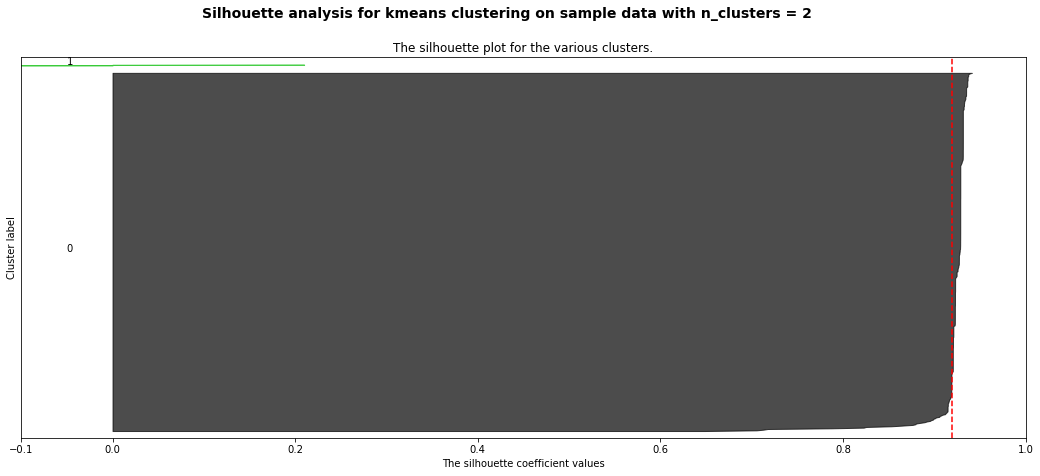

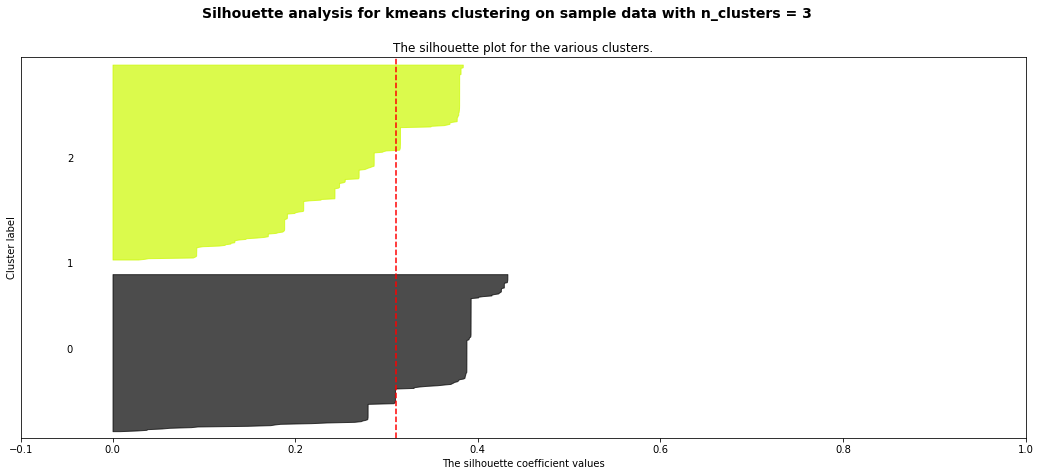

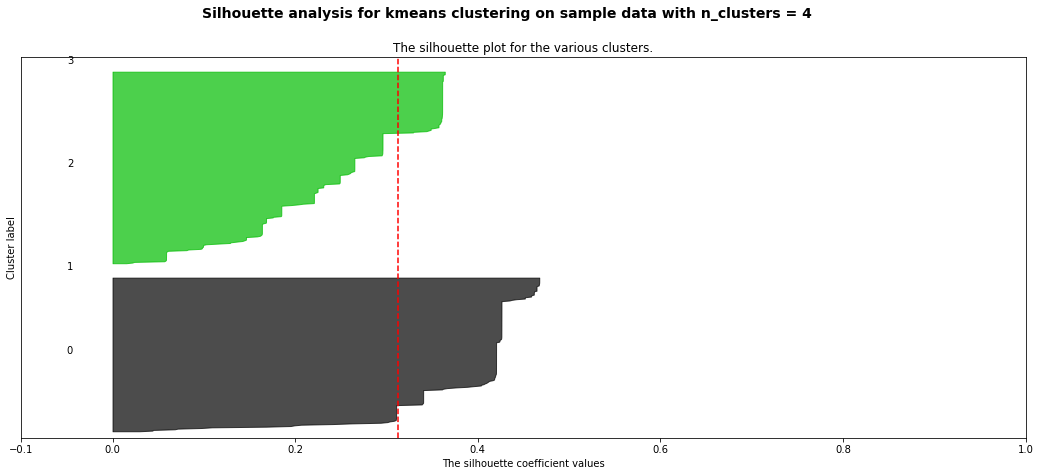

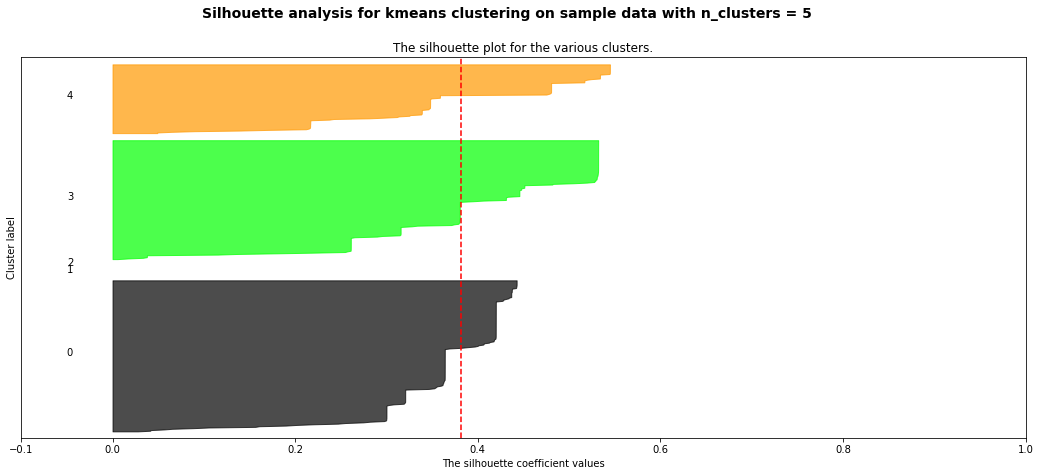

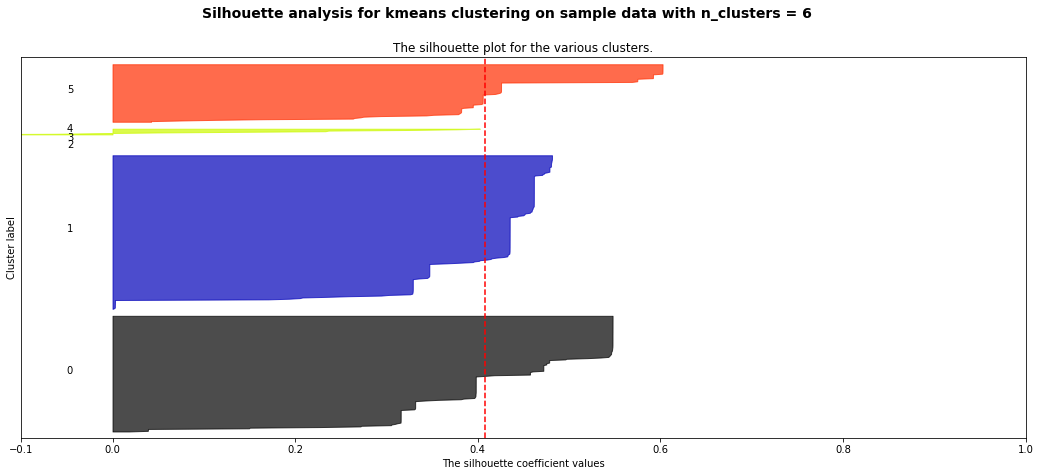

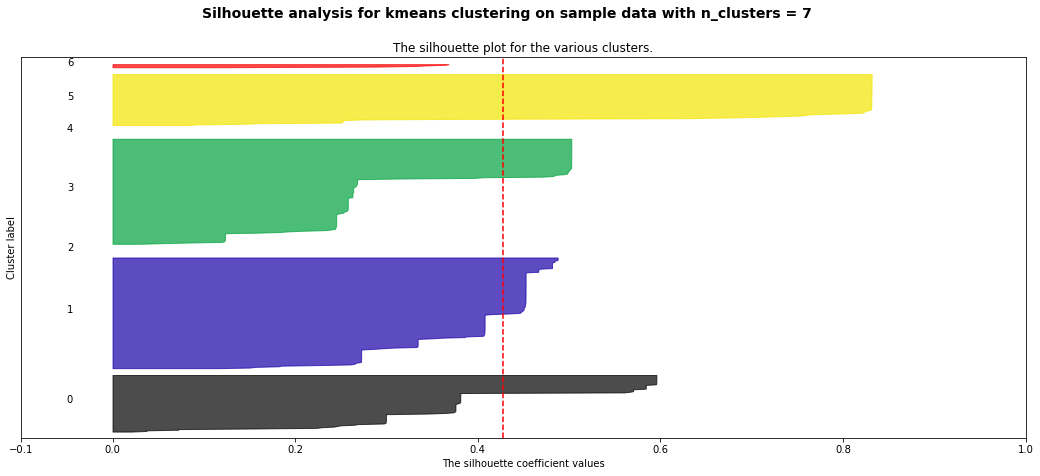

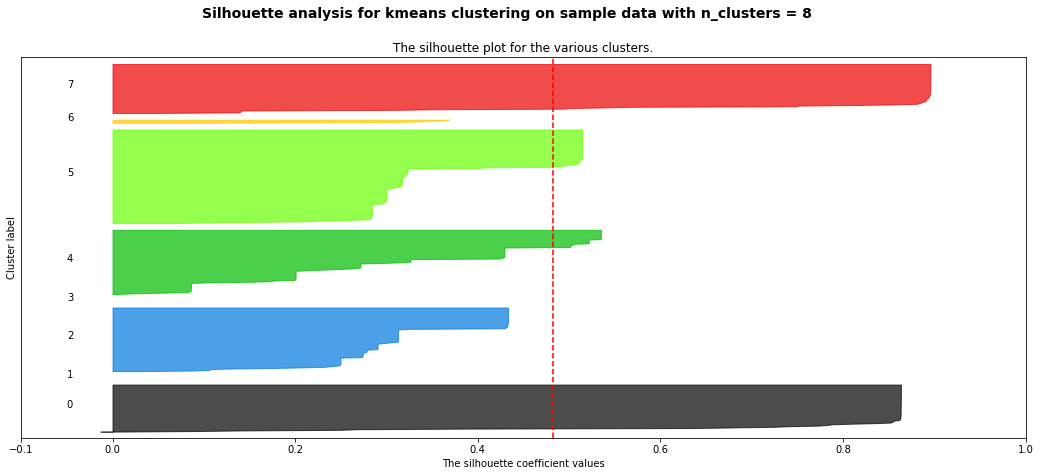

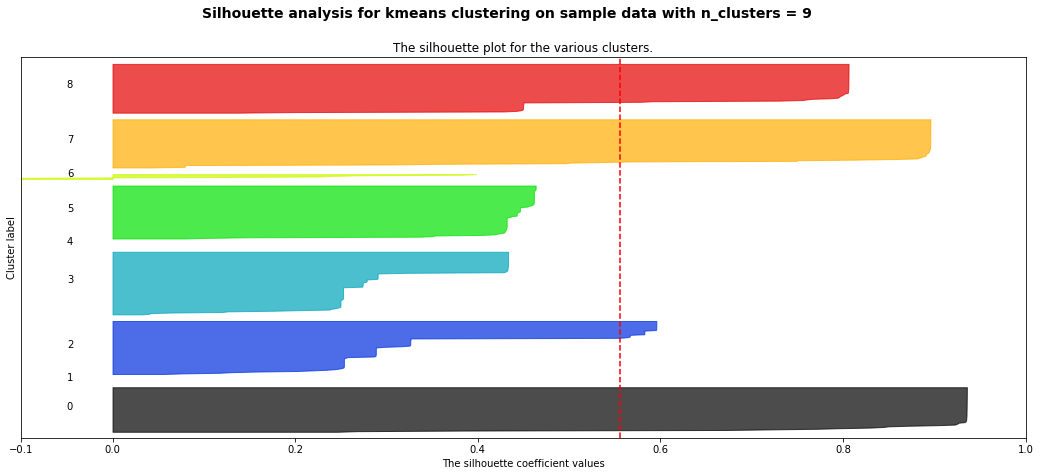

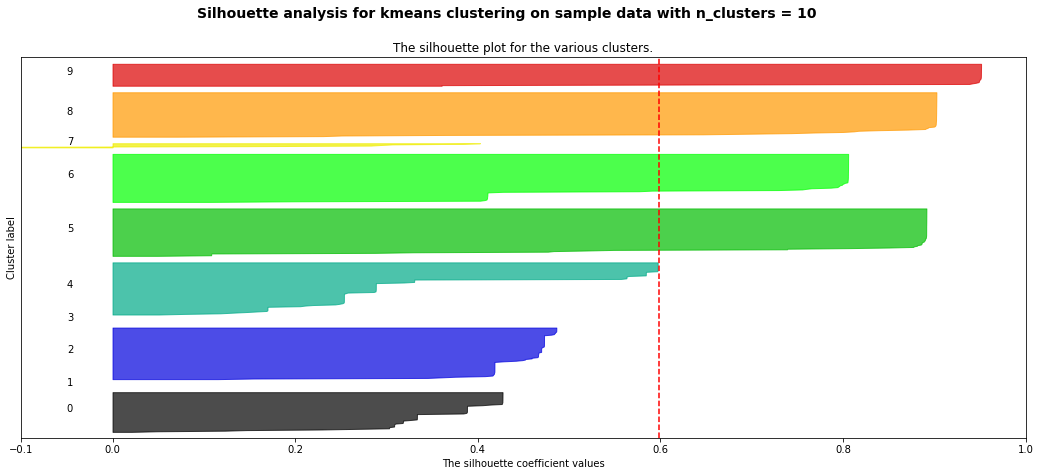

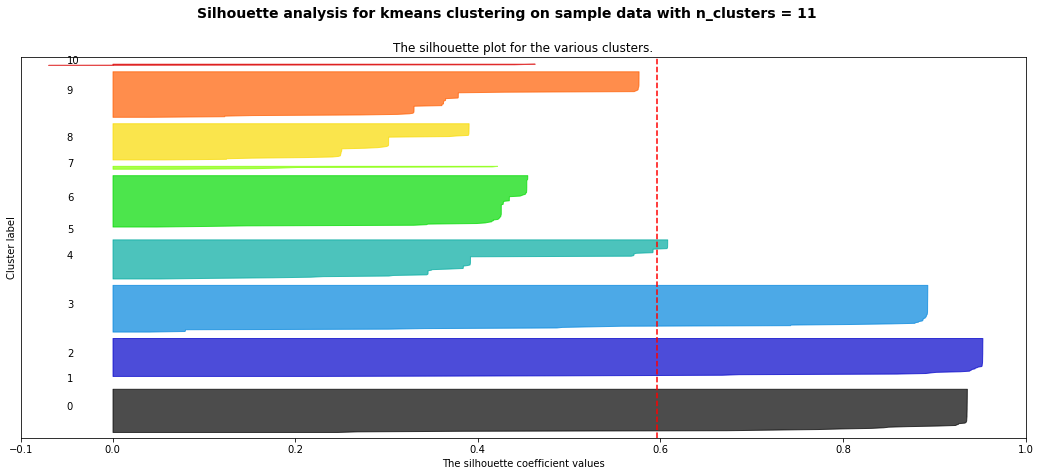

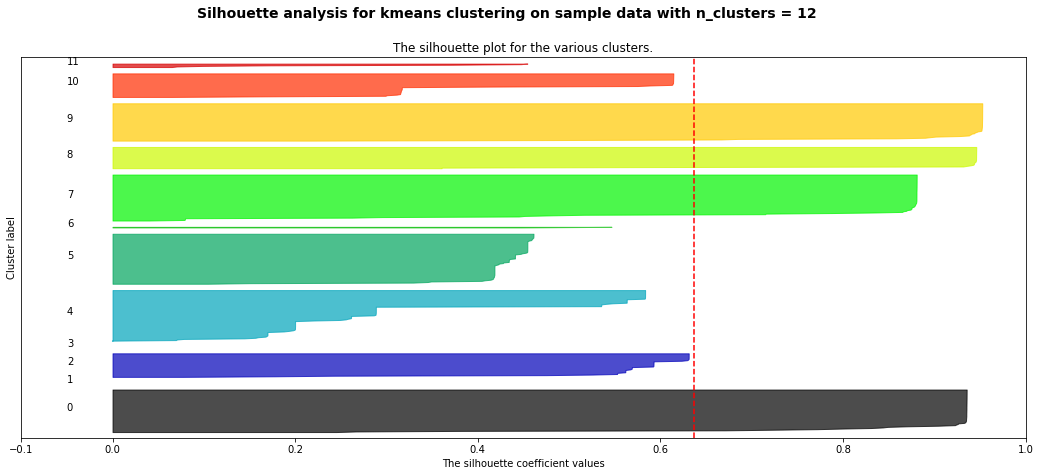

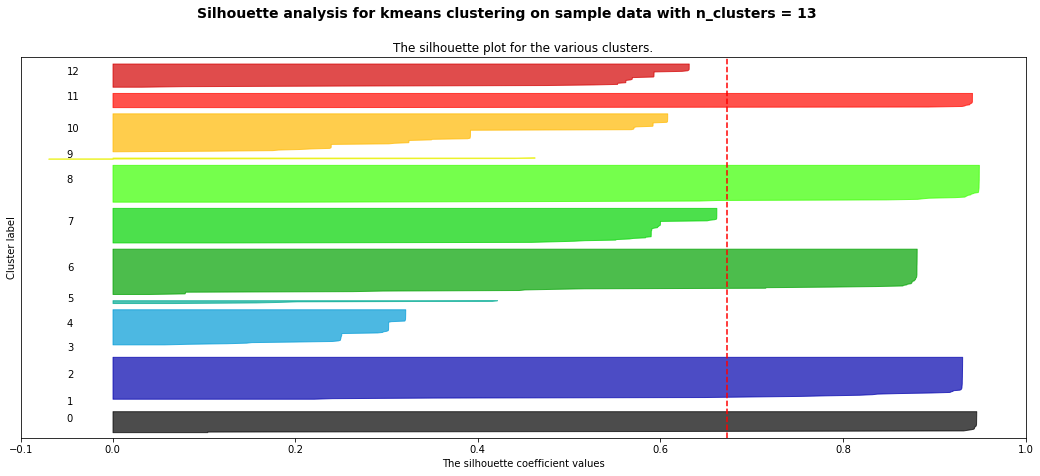

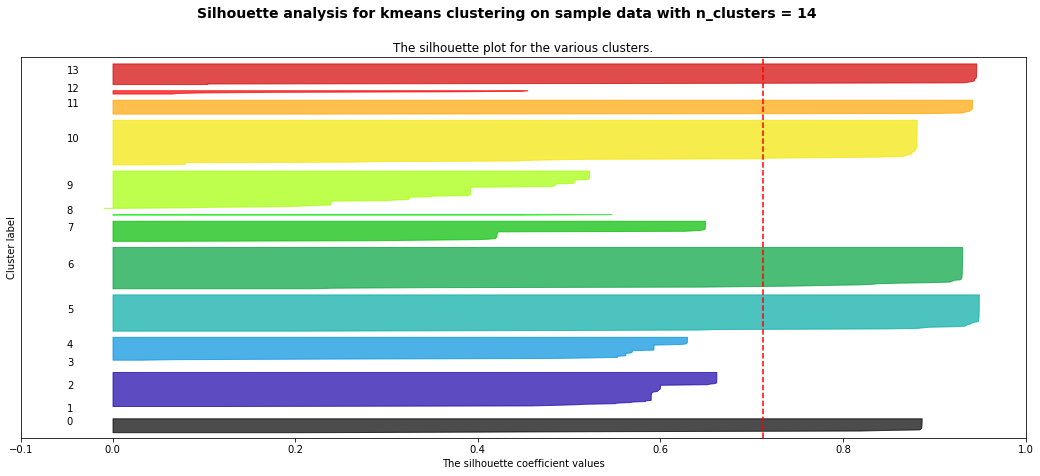

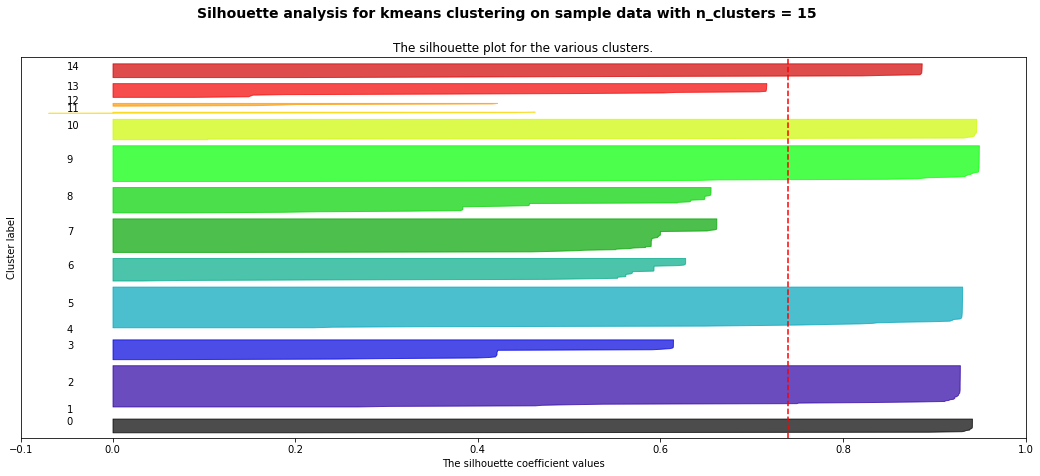

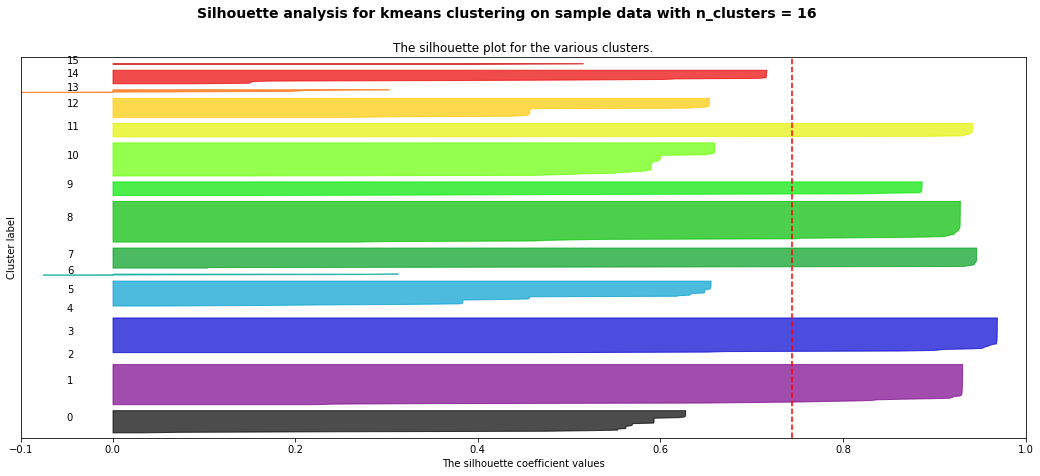

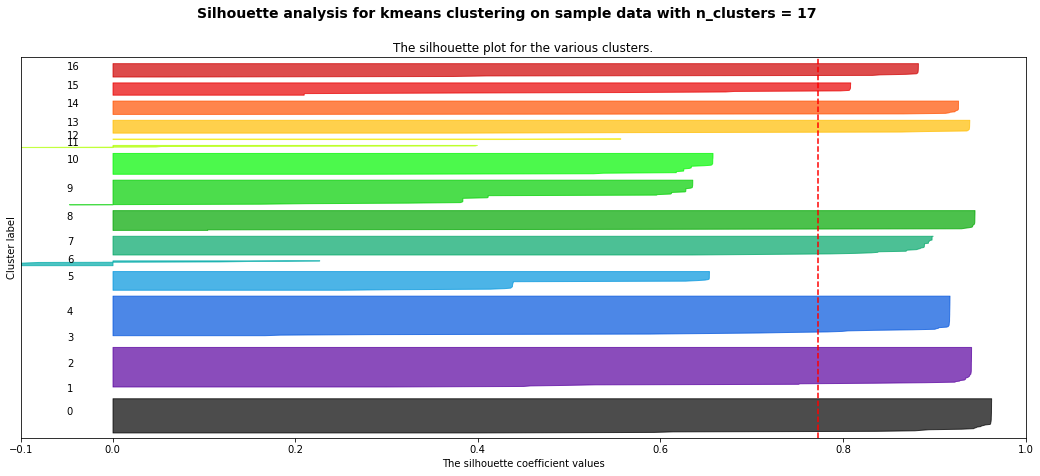

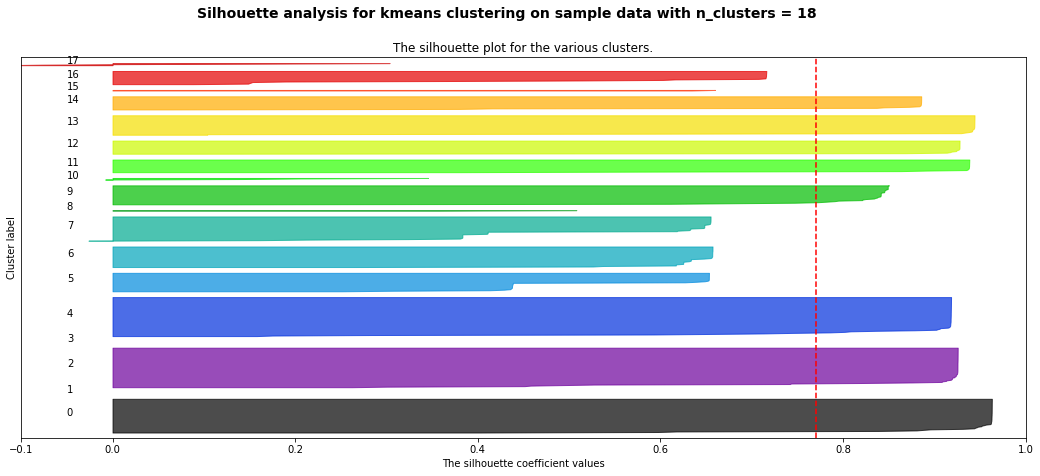

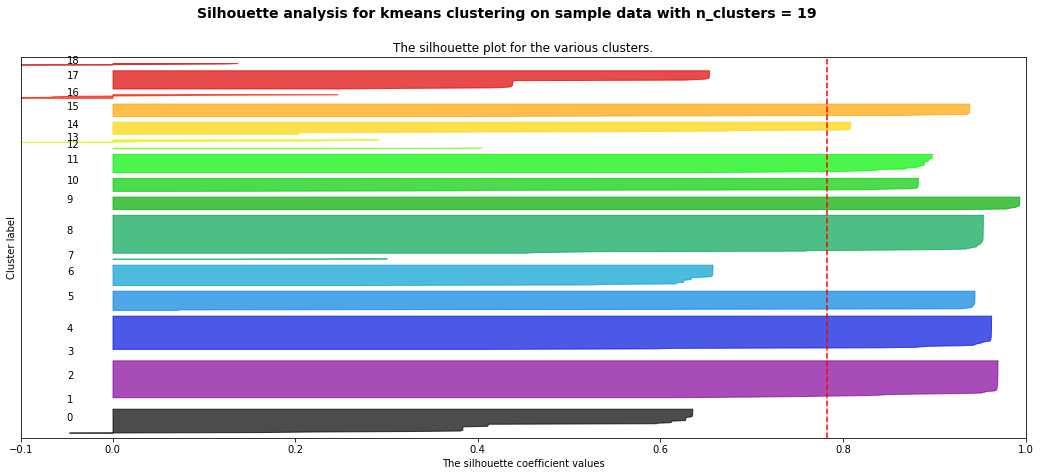

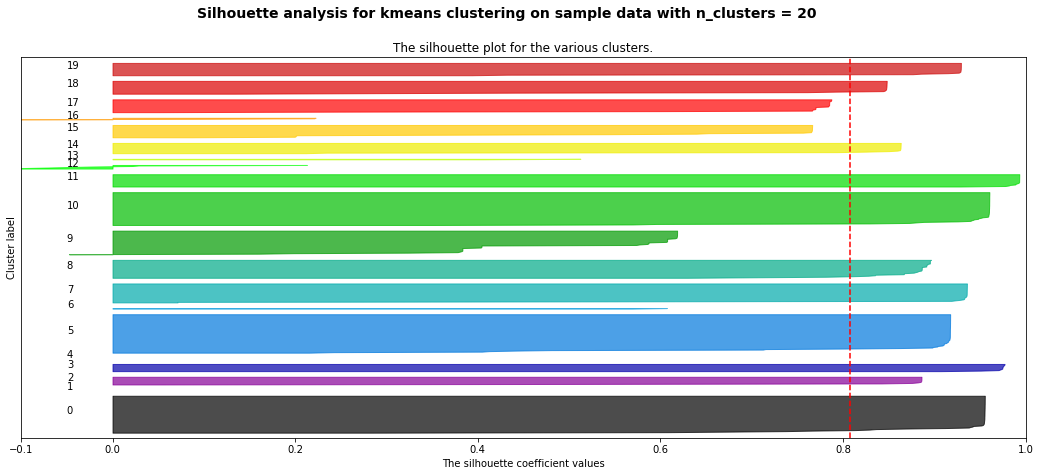

In [75]:
 # Silhouette score
X = df_pca.values
range_n_clusters  = list(range(2,21))

getSilhouette(X, range_n_clusters, "kmeans")

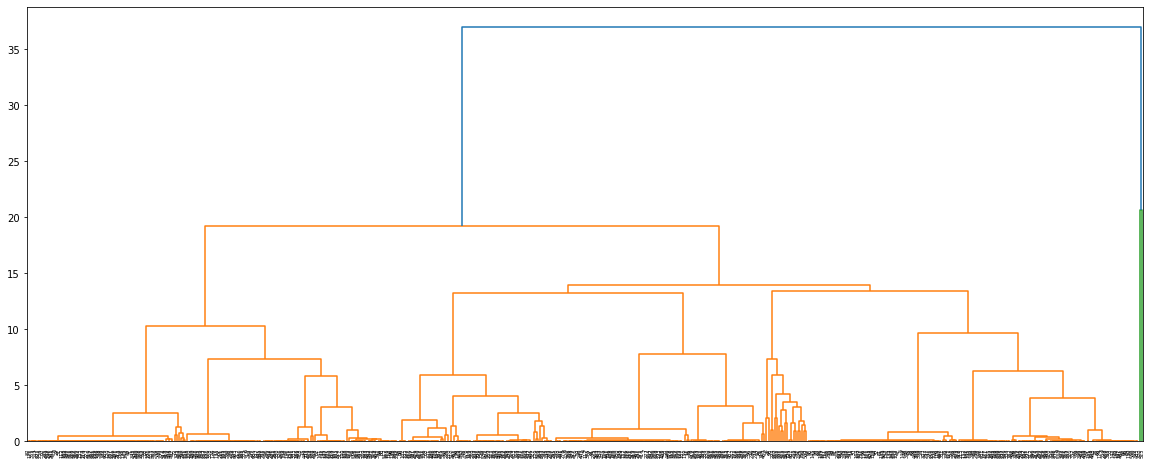

In [76]:
# Hierarchicalalal Agglomerative
mergings = linkage(df_pca, method='ward')

plt.figure(figsize=(20,8))
dendrogram(mergings,
          leaf_rotation=90,
          leaf_font_size=5)
plt.show()

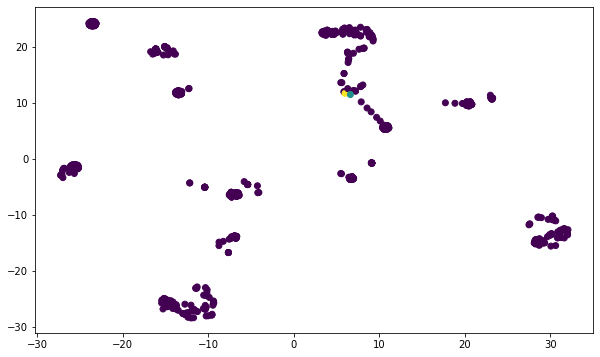

In [87]:
# Initializing model with K = 2
k = 3
model = KMeans(n_clusters=k, random_state=42)

# Fitting model
model.fit(df_scale)

# predictions
k_labels = model.predict(df_scale)

plt.figure(figsize=(10, 6))
plt.scatter(tsne_df["Feature1"], tsne_df["Feature2"], c=k_labels)
plt.show()

In [88]:
k_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [89]:
# Create a new data frame with the crytpo names and our k labels to
df_names = pd.DataFrame()
df_names["CoinName"] = crypto_names
df_names["Cluster"] = k_labels

df_names.head()

,CoinName,Cluster
0,42 Coin,0
1,404Coin,0
2,EliteCoin,0
3,Bitcoin,0
4,Ethereum,0


In [90]:
df_names.loc[df_names.Cluster == 1]

,CoinName,Cluster
525,BitTorrent,1


In [91]:
df.loc[df.CoinName.isin(["TurtleCoin", "BitTorrent"])]

,Unnamed: 0,CoinName,Algorithm,IsTrading,ProofType,TotalCoinsMined,TotalCoinSupply
903,TRTL,TurtleCoin,CryptoNight,True,PoW,5.313984e+10,1000000000000
1234,BTT,BitTorrent,TRC10,True,DPoS,9.899887e+11,990000000000


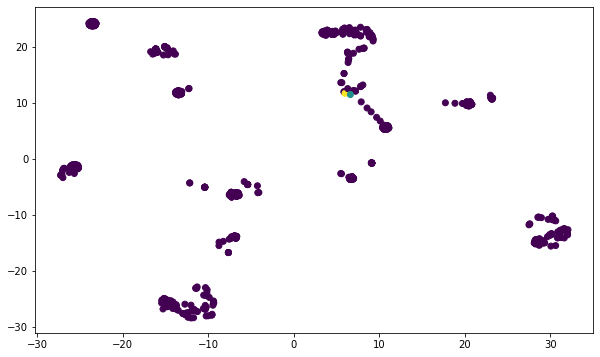

In [94]:
k = 3
model = KMeans(n_clusters=k, random_state=42)

# Fitting model
model.fit(df_scale)

# predictions
k_labels = model.predict(df_scale)

plt.figure(figsize=(10, 6))
plt.scatter(tsne_df["Feature1"], tsne_df["Feature2"], c=k_labels)
plt.show()

## Recommendation

### There are no real clusters we could make with out creating outliers.
